# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
# !unzip processed_celeba_small.zip

In [2]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    transform = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor()])
    
    dataset = datasets.ImageFolder(data_dir, transform=transform)
    
    # TODO: Implement function and return a dataloader
    data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                             batch_size=batch_size,
                                             shuffle=True)
    
    return data_loader

## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [5]:
# Define function hyperparameters
batch_size = 64
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

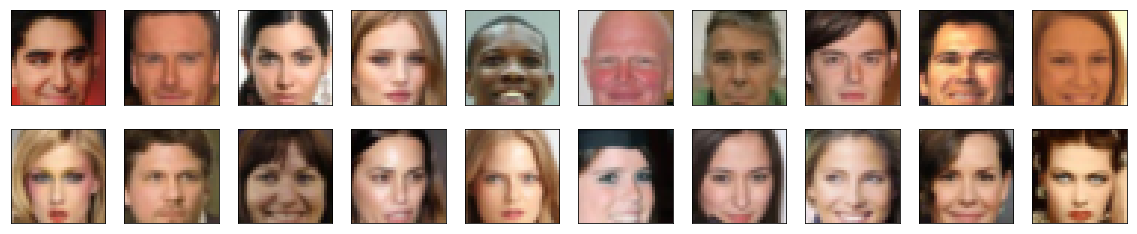

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9922)
Max:  tensor(0.8510)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers = []
    conv_layer = nn.Conv2d(in_channels = in_channels, out_channels = out_channels,
                           kernel_size = kernel_size, stride = stride, padding = padding, bias = False)
    
    layers.append(conv_layer)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [11]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        self.conv_dim = conv_dim
        
        self.conv1 = conv(3, conv_dim, 4, batch_norm = False)
        self.conv2 = conv(conv_dim, conv_dim * 2, 4)          
        self.conv3 = conv(conv_dim * 2, conv_dim * 4, 4)
        
        # Final layer
        self.fc = nn.Linear(conv_dim * 4 * 4 * 4, 1)  
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        
        # flatten
        out = out.view(-1, self.conv_dim * 4 * 4 * 4)
        
        out = self.fc(out)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [12]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)

    layers.append(transpose_conv_layer)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))

    return nn.Sequential(*layers)

In [13]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        self.fc = nn.Linear(z_size, conv_dim * 4 * 4 * 4)
        
        self.t_conv1 = deconv(conv_dim * 4, conv_dim * 2, 4)
        self.t_conv2 = deconv(conv_dim * 2, conv_dim, 4)
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        out = self.fc(x)
        out = out.view(-1, self.conv_dim * 4, 4, 4)
        
        out = F.relu(self.t_conv1(out))
        out = F.relu(self.t_conv2(out))
        out = F.tanh(self.t_conv3(out))

        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [14]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    if classname.find('Conv') != -1 or classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0, 0.02)
    if hasattr(m, 'bias') and m.bias is not None:
        m.bias.data.fill_(0)
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [16]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [18]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    loss = torch.mean((D_out - 1)**2)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    loss = torch.mean(D_out**2)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [19]:
import torch.optim as optim

# Create optimizers for the discriminator D and generator G
lr = 0.0002
beta1 = 0.5
beta2 = 0.999

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [20]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            d_optimizer.zero_grad()
            
            # 1. Train the discriminator on real and fake images
            if train_on_gpu:
                real_images = real_images.cuda()
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
            
            # generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            
            # add real loss and fake loss
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            # generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            # compute the discriminator losses on fake images 
            D_fake = D(fake_images)
            
            # use real loss to flip labels
            g_loss = real_loss(D_fake)
            g_loss.backward()
            g_optimizer.step()
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [21]:
# set number of epochs 
n_epochs = 100


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/  100] | d_loss: 0.8772 | g_loss: 0.7576
Epoch [    1/  100] | d_loss: 0.0889 | g_loss: 1.0586
Epoch [    1/  100] | d_loss: 0.0914 | g_loss: 0.6141
Epoch [    1/  100] | d_loss: 0.1400 | g_loss: 1.0218
Epoch [    1/  100] | d_loss: 0.0710 | g_loss: 0.8813
Epoch [    1/  100] | d_loss: 0.0718 | g_loss: 1.0235
Epoch [    1/  100] | d_loss: 0.1192 | g_loss: 0.5425
Epoch [    1/  100] | d_loss: 0.1465 | g_loss: 0.6198
Epoch [    1/  100] | d_loss: 1.0449 | g_loss: 2.3302
Epoch [    1/  100] | d_loss: 0.1502 | g_loss: 1.0198
Epoch [    1/  100] | d_loss: 0.2293 | g_loss: 0.7524
Epoch [    1/  100] | d_loss: 0.2186 | g_loss: 0.7278
Epoch [    1/  100] | d_loss: 0.2038 | g_loss: 0.6259
Epoch [    1/  100] | d_loss: 0.2404 | g_loss: 0.6222
Epoch [    1/  100] | d_loss: 0.2550 | g_loss: 0.8477
Epoch [    1/  100] | d_loss: 1.2367 | g_loss: 0.0350
Epoch [    1/  100] | d_loss: 0.2273 | g_loss: 0.6708
Epoch [    1/  100] | d_loss: 0.2749 | g_loss: 0.4595
Epoch [    1/  100] | d_loss

Epoch [    6/  100] | d_loss: 0.3002 | g_loss: 0.5434
Epoch [    6/  100] | d_loss: 0.3055 | g_loss: 0.4248
Epoch [    6/  100] | d_loss: 0.4466 | g_loss: 0.8905
Epoch [    6/  100] | d_loss: 0.2722 | g_loss: 0.5345
Epoch [    6/  100] | d_loss: 0.3481 | g_loss: 0.4246
Epoch [    6/  100] | d_loss: 0.3017 | g_loss: 0.3773
Epoch [    6/  100] | d_loss: 0.4866 | g_loss: 0.4771
Epoch [    6/  100] | d_loss: 0.3168 | g_loss: 0.5006
Epoch [    6/  100] | d_loss: 0.2996 | g_loss: 0.5820
Epoch [    6/  100] | d_loss: 0.2508 | g_loss: 0.4663
Epoch [    6/  100] | d_loss: 0.3072 | g_loss: 0.4583
Epoch [    6/  100] | d_loss: 0.3476 | g_loss: 0.4559
Epoch [    6/  100] | d_loss: 0.3161 | g_loss: 0.7156
Epoch [    6/  100] | d_loss: 0.3483 | g_loss: 0.7005
Epoch [    6/  100] | d_loss: 0.3151 | g_loss: 0.6705
Epoch [    6/  100] | d_loss: 0.4439 | g_loss: 0.4380
Epoch [    6/  100] | d_loss: 0.3224 | g_loss: 0.2651
Epoch [    6/  100] | d_loss: 0.3150 | g_loss: 0.5062
Epoch [    6/  100] | d_loss

Epoch [   11/  100] | d_loss: 0.3836 | g_loss: 0.5763
Epoch [   11/  100] | d_loss: 0.2295 | g_loss: 0.5228
Epoch [   11/  100] | d_loss: 0.2373 | g_loss: 0.9841
Epoch [   11/  100] | d_loss: 0.2759 | g_loss: 0.6790
Epoch [   11/  100] | d_loss: 0.1051 | g_loss: 0.7708
Epoch [   11/  100] | d_loss: 0.1958 | g_loss: 0.7051
Epoch [   11/  100] | d_loss: 0.1775 | g_loss: 0.5827
Epoch [   11/  100] | d_loss: 0.2767 | g_loss: 0.7251
Epoch [   11/  100] | d_loss: 0.3659 | g_loss: 0.6299
Epoch [   11/  100] | d_loss: 0.2839 | g_loss: 0.4732
Epoch [   11/  100] | d_loss: 0.2516 | g_loss: 0.9904
Epoch [   11/  100] | d_loss: 0.2555 | g_loss: 0.9915
Epoch [   11/  100] | d_loss: 0.3125 | g_loss: 0.6662
Epoch [   11/  100] | d_loss: 0.3308 | g_loss: 0.4100
Epoch [   11/  100] | d_loss: 0.3000 | g_loss: 1.1106
Epoch [   12/  100] | d_loss: 0.2769 | g_loss: 0.6916
Epoch [   12/  100] | d_loss: 0.1945 | g_loss: 0.5127
Epoch [   12/  100] | d_loss: 0.3045 | g_loss: 0.2423
Epoch [   12/  100] | d_loss

Epoch [   16/  100] | d_loss: 0.2707 | g_loss: 0.7274
Epoch [   16/  100] | d_loss: 0.1213 | g_loss: 0.7124
Epoch [   16/  100] | d_loss: 0.1927 | g_loss: 0.9637
Epoch [   16/  100] | d_loss: 0.1765 | g_loss: 0.6573
Epoch [   16/  100] | d_loss: 0.1812 | g_loss: 0.6290
Epoch [   16/  100] | d_loss: 0.1972 | g_loss: 0.5509
Epoch [   16/  100] | d_loss: 0.1760 | g_loss: 0.7770
Epoch [   16/  100] | d_loss: 0.4811 | g_loss: 0.8279
Epoch [   17/  100] | d_loss: 0.5304 | g_loss: 0.2932
Epoch [   17/  100] | d_loss: 0.1531 | g_loss: 0.7938
Epoch [   17/  100] | d_loss: 0.2537 | g_loss: 0.5383
Epoch [   17/  100] | d_loss: 0.1660 | g_loss: 0.8901
Epoch [   17/  100] | d_loss: 0.1288 | g_loss: 1.0277
Epoch [   17/  100] | d_loss: 0.1714 | g_loss: 0.7211
Epoch [   17/  100] | d_loss: 0.2356 | g_loss: 0.8330
Epoch [   17/  100] | d_loss: 0.1799 | g_loss: 0.8254
Epoch [   17/  100] | d_loss: 0.4233 | g_loss: 0.8628
Epoch [   17/  100] | d_loss: 0.1587 | g_loss: 0.6623
Epoch [   17/  100] | d_loss

Epoch [   21/  100] | d_loss: 0.4802 | g_loss: 0.2614
Epoch [   22/  100] | d_loss: 0.5544 | g_loss: 0.2296
Epoch [   22/  100] | d_loss: 0.5211 | g_loss: 0.2430
Epoch [   22/  100] | d_loss: 0.5127 | g_loss: 0.2794
Epoch [   22/  100] | d_loss: 0.5021 | g_loss: 0.2657
Epoch [   22/  100] | d_loss: 0.4836 | g_loss: 0.2810
Epoch [   22/  100] | d_loss: 0.5232 | g_loss: 0.2945
Epoch [   22/  100] | d_loss: 0.5173 | g_loss: 0.2655
Epoch [   22/  100] | d_loss: 0.5335 | g_loss: 0.2549
Epoch [   22/  100] | d_loss: 0.5142 | g_loss: 0.2914
Epoch [   22/  100] | d_loss: 0.4961 | g_loss: 0.2428
Epoch [   22/  100] | d_loss: 0.5249 | g_loss: 0.2786
Epoch [   22/  100] | d_loss: 0.5031 | g_loss: 0.2744
Epoch [   22/  100] | d_loss: 0.5025 | g_loss: 0.2461
Epoch [   22/  100] | d_loss: 0.4787 | g_loss: 0.2485
Epoch [   22/  100] | d_loss: 0.5012 | g_loss: 0.2553
Epoch [   22/  100] | d_loss: 0.4714 | g_loss: 0.3019
Epoch [   22/  100] | d_loss: 0.4996 | g_loss: 0.2554
Epoch [   22/  100] | d_loss

Epoch [   27/  100] | d_loss: 0.4777 | g_loss: 0.3244
Epoch [   27/  100] | d_loss: 0.5128 | g_loss: 0.2989
Epoch [   27/  100] | d_loss: 0.5181 | g_loss: 0.2886
Epoch [   27/  100] | d_loss: 0.4990 | g_loss: 0.2764
Epoch [   27/  100] | d_loss: 0.4761 | g_loss: 0.2733
Epoch [   27/  100] | d_loss: 0.4870 | g_loss: 0.2899
Epoch [   27/  100] | d_loss: 0.4858 | g_loss: 0.2709
Epoch [   27/  100] | d_loss: 0.4761 | g_loss: 0.3170
Epoch [   27/  100] | d_loss: 0.4877 | g_loss: 0.2355
Epoch [   27/  100] | d_loss: 0.5488 | g_loss: 0.2584
Epoch [   27/  100] | d_loss: 0.4933 | g_loss: 0.3291
Epoch [   27/  100] | d_loss: 0.5076 | g_loss: 0.2590
Epoch [   27/  100] | d_loss: 0.4994 | g_loss: 0.2666
Epoch [   27/  100] | d_loss: 0.4817 | g_loss: 0.2424
Epoch [   27/  100] | d_loss: 0.5181 | g_loss: 0.2815
Epoch [   27/  100] | d_loss: 0.4982 | g_loss: 0.2638
Epoch [   27/  100] | d_loss: 0.4907 | g_loss: 0.2700
Epoch [   27/  100] | d_loss: 0.5297 | g_loss: 0.2561
Epoch [   27/  100] | d_loss

Epoch [   32/  100] | d_loss: 0.3798 | g_loss: 0.3492
Epoch [   32/  100] | d_loss: 0.3370 | g_loss: 0.6330
Epoch [   32/  100] | d_loss: 0.3797 | g_loss: 0.3811
Epoch [   32/  100] | d_loss: 0.3794 | g_loss: 0.3140
Epoch [   32/  100] | d_loss: 0.3711 | g_loss: 0.4987
Epoch [   32/  100] | d_loss: 0.4046 | g_loss: 0.5153
Epoch [   32/  100] | d_loss: 0.3647 | g_loss: 0.2846
Epoch [   32/  100] | d_loss: 0.3877 | g_loss: 0.4387
Epoch [   32/  100] | d_loss: 0.3703 | g_loss: 0.3447
Epoch [   32/  100] | d_loss: 0.3722 | g_loss: 0.3072
Epoch [   32/  100] | d_loss: 0.4205 | g_loss: 0.5349
Epoch [   32/  100] | d_loss: 0.3800 | g_loss: 0.4674
Epoch [   32/  100] | d_loss: 0.3065 | g_loss: 0.4913
Epoch [   32/  100] | d_loss: 0.4187 | g_loss: 0.6008
Epoch [   32/  100] | d_loss: 0.3523 | g_loss: 0.3770
Epoch [   32/  100] | d_loss: 0.4034 | g_loss: 0.4273
Epoch [   33/  100] | d_loss: 0.8392 | g_loss: 0.8944
Epoch [   33/  100] | d_loss: 0.3255 | g_loss: 0.4742
Epoch [   33/  100] | d_loss

Epoch [   37/  100] | d_loss: 0.2424 | g_loss: 0.4893
Epoch [   37/  100] | d_loss: 0.2098 | g_loss: 0.7975
Epoch [   37/  100] | d_loss: 0.2215 | g_loss: 0.7534
Epoch [   37/  100] | d_loss: 0.2602 | g_loss: 0.5114
Epoch [   37/  100] | d_loss: 0.3307 | g_loss: 1.0140
Epoch [   37/  100] | d_loss: 0.2429 | g_loss: 0.6726
Epoch [   37/  100] | d_loss: 0.1414 | g_loss: 0.6155
Epoch [   37/  100] | d_loss: 0.2489 | g_loss: 0.8360
Epoch [   37/  100] | d_loss: 0.2396 | g_loss: 0.4360
Epoch [   38/  100] | d_loss: 0.3656 | g_loss: 1.1229
Epoch [   38/  100] | d_loss: 0.1920 | g_loss: 1.0025
Epoch [   38/  100] | d_loss: 0.2806 | g_loss: 0.2512
Epoch [   38/  100] | d_loss: 0.2576 | g_loss: 0.5649
Epoch [   38/  100] | d_loss: 0.2289 | g_loss: 0.5988
Epoch [   38/  100] | d_loss: 0.1761 | g_loss: 0.6297
Epoch [   38/  100] | d_loss: 0.1408 | g_loss: 0.7160
Epoch [   38/  100] | d_loss: 0.2199 | g_loss: 0.5196
Epoch [   38/  100] | d_loss: 0.3729 | g_loss: 1.0200
Epoch [   38/  100] | d_loss

Epoch [   42/  100] | d_loss: 0.2847 | g_loss: 0.4806
Epoch [   42/  100] | d_loss: 0.2295 | g_loss: 0.6088
Epoch [   43/  100] | d_loss: 0.1391 | g_loss: 0.7219
Epoch [   43/  100] | d_loss: 0.3027 | g_loss: 0.4669
Epoch [   43/  100] | d_loss: 0.1633 | g_loss: 0.4576
Epoch [   43/  100] | d_loss: 0.2708 | g_loss: 0.8058
Epoch [   43/  100] | d_loss: 0.1861 | g_loss: 0.9739
Epoch [   43/  100] | d_loss: 0.1922 | g_loss: 0.7359
Epoch [   43/  100] | d_loss: 0.1859 | g_loss: 0.6242
Epoch [   43/  100] | d_loss: 0.1055 | g_loss: 0.7635
Epoch [   43/  100] | d_loss: 0.2903 | g_loss: 0.9472
Epoch [   43/  100] | d_loss: 0.1834 | g_loss: 0.4735
Epoch [   43/  100] | d_loss: 0.1684 | g_loss: 0.6301
Epoch [   43/  100] | d_loss: 0.1773 | g_loss: 0.7615
Epoch [   43/  100] | d_loss: 0.1562 | g_loss: 0.5488
Epoch [   43/  100] | d_loss: 0.0914 | g_loss: 0.8757
Epoch [   43/  100] | d_loss: 0.1902 | g_loss: 0.7577
Epoch [   43/  100] | d_loss: 0.2139 | g_loss: 0.9214
Epoch [   43/  100] | d_loss

Epoch [   48/  100] | d_loss: 0.1920 | g_loss: 0.8189
Epoch [   48/  100] | d_loss: 0.1064 | g_loss: 0.7952
Epoch [   48/  100] | d_loss: 0.2504 | g_loss: 0.8009
Epoch [   48/  100] | d_loss: 0.1430 | g_loss: 0.7322
Epoch [   48/  100] | d_loss: 0.1360 | g_loss: 0.8106
Epoch [   48/  100] | d_loss: 0.1640 | g_loss: 1.0583
Epoch [   48/  100] | d_loss: 0.1393 | g_loss: 1.4077
Epoch [   48/  100] | d_loss: 0.1616 | g_loss: 1.1407
Epoch [   48/  100] | d_loss: 0.0821 | g_loss: 0.7966
Epoch [   48/  100] | d_loss: 0.0893 | g_loss: 0.8095
Epoch [   48/  100] | d_loss: 0.1608 | g_loss: 0.4606
Epoch [   48/  100] | d_loss: 0.2200 | g_loss: 0.5890
Epoch [   48/  100] | d_loss: 0.1073 | g_loss: 0.8133
Epoch [   48/  100] | d_loss: 0.1467 | g_loss: 0.4669
Epoch [   48/  100] | d_loss: 0.0958 | g_loss: 0.7620
Epoch [   48/  100] | d_loss: 0.2961 | g_loss: 0.3821
Epoch [   48/  100] | d_loss: 0.1757 | g_loss: 0.6903
Epoch [   48/  100] | d_loss: 0.1324 | g_loss: 0.5691
Epoch [   48/  100] | d_loss

Epoch [   53/  100] | d_loss: 0.1670 | g_loss: 0.8593
Epoch [   53/  100] | d_loss: 0.1213 | g_loss: 0.8787
Epoch [   53/  100] | d_loss: 0.1324 | g_loss: 0.6900
Epoch [   53/  100] | d_loss: 0.0586 | g_loss: 0.8854
Epoch [   53/  100] | d_loss: 0.0885 | g_loss: 0.8778
Epoch [   53/  100] | d_loss: 0.1392 | g_loss: 0.8153
Epoch [   53/  100] | d_loss: 0.1466 | g_loss: 0.9194
Epoch [   53/  100] | d_loss: 0.1239 | g_loss: 0.7930
Epoch [   53/  100] | d_loss: 0.1795 | g_loss: 0.8170
Epoch [   53/  100] | d_loss: 0.1888 | g_loss: 0.7106
Epoch [   53/  100] | d_loss: 0.1946 | g_loss: 0.7728
Epoch [   53/  100] | d_loss: 0.0900 | g_loss: 0.8378
Epoch [   53/  100] | d_loss: 0.1535 | g_loss: 0.6519
Epoch [   53/  100] | d_loss: 0.1158 | g_loss: 0.8069
Epoch [   53/  100] | d_loss: 0.0748 | g_loss: 0.8045
Epoch [   53/  100] | d_loss: 0.1482 | g_loss: 0.7626
Epoch [   53/  100] | d_loss: 0.2781 | g_loss: 0.7678
Epoch [   54/  100] | d_loss: 0.2794 | g_loss: 0.6246
Epoch [   54/  100] | d_loss

Epoch [   58/  100] | d_loss: 0.2605 | g_loss: 1.0174
Epoch [   58/  100] | d_loss: 0.1606 | g_loss: 0.5564
Epoch [   58/  100] | d_loss: 0.1397 | g_loss: 0.6551
Epoch [   58/  100] | d_loss: 0.1011 | g_loss: 0.6002
Epoch [   58/  100] | d_loss: 0.1330 | g_loss: 0.6985
Epoch [   58/  100] | d_loss: 0.1005 | g_loss: 1.0724
Epoch [   58/  100] | d_loss: 0.1500 | g_loss: 0.8146
Epoch [   58/  100] | d_loss: 0.1551 | g_loss: 0.7112
Epoch [   58/  100] | d_loss: 0.2795 | g_loss: 0.7354
Epoch [   58/  100] | d_loss: 0.1123 | g_loss: 1.0039
Epoch [   59/  100] | d_loss: 0.4038 | g_loss: 0.9671
Epoch [   59/  100] | d_loss: 0.0552 | g_loss: 0.5354
Epoch [   59/  100] | d_loss: 0.1230 | g_loss: 0.8175
Epoch [   59/  100] | d_loss: 0.1014 | g_loss: 0.6789
Epoch [   59/  100] | d_loss: 0.3706 | g_loss: 1.3422
Epoch [   59/  100] | d_loss: 0.1714 | g_loss: 0.6392
Epoch [   59/  100] | d_loss: 0.4114 | g_loss: 0.3154
Epoch [   59/  100] | d_loss: 0.2893 | g_loss: 0.8467
Epoch [   59/  100] | d_loss

Epoch [   63/  100] | d_loss: 0.1895 | g_loss: 0.7116
Epoch [   63/  100] | d_loss: 0.0634 | g_loss: 0.9176
Epoch [   63/  100] | d_loss: 0.0683 | g_loss: 0.6693
Epoch [   64/  100] | d_loss: 0.0938 | g_loss: 0.4850
Epoch [   64/  100] | d_loss: 0.2772 | g_loss: 1.0702
Epoch [   64/  100] | d_loss: 0.0569 | g_loss: 0.9207
Epoch [   64/  100] | d_loss: 0.1936 | g_loss: 0.8738
Epoch [   64/  100] | d_loss: 0.1261 | g_loss: 0.9671
Epoch [   64/  100] | d_loss: 0.0715 | g_loss: 0.6734
Epoch [   64/  100] | d_loss: 0.1163 | g_loss: 0.6997
Epoch [   64/  100] | d_loss: 0.1146 | g_loss: 0.4381
Epoch [   64/  100] | d_loss: 0.2117 | g_loss: 1.0519
Epoch [   64/  100] | d_loss: 0.0755 | g_loss: 0.7791
Epoch [   64/  100] | d_loss: 0.1409 | g_loss: 0.8682
Epoch [   64/  100] | d_loss: 0.1438 | g_loss: 0.8970
Epoch [   64/  100] | d_loss: 0.0869 | g_loss: 0.8715
Epoch [   64/  100] | d_loss: 0.1307 | g_loss: 0.8753
Epoch [   64/  100] | d_loss: 0.0887 | g_loss: 0.4192
Epoch [   64/  100] | d_loss

Epoch [   69/  100] | d_loss: 0.1180 | g_loss: 0.6812
Epoch [   69/  100] | d_loss: 0.2321 | g_loss: 1.1315
Epoch [   69/  100] | d_loss: 0.1704 | g_loss: 0.8640
Epoch [   69/  100] | d_loss: 0.1519 | g_loss: 0.5867
Epoch [   69/  100] | d_loss: 0.0844 | g_loss: 0.8067
Epoch [   69/  100] | d_loss: 0.0848 | g_loss: 0.9028
Epoch [   69/  100] | d_loss: 0.2308 | g_loss: 0.8623
Epoch [   69/  100] | d_loss: 0.1119 | g_loss: 0.7799
Epoch [   69/  100] | d_loss: 0.0757 | g_loss: 0.7962
Epoch [   69/  100] | d_loss: 0.1356 | g_loss: 0.6378
Epoch [   69/  100] | d_loss: 0.1655 | g_loss: 0.5620
Epoch [   69/  100] | d_loss: 0.1179 | g_loss: 0.5464
Epoch [   69/  100] | d_loss: 0.2849 | g_loss: 1.1641
Epoch [   69/  100] | d_loss: 0.0905 | g_loss: 1.0624
Epoch [   69/  100] | d_loss: 0.0591 | g_loss: 0.8737
Epoch [   69/  100] | d_loss: 0.1752 | g_loss: 1.0859
Epoch [   69/  100] | d_loss: 0.1069 | g_loss: 1.0346
Epoch [   69/  100] | d_loss: 0.0505 | g_loss: 0.7170
Epoch [   69/  100] | d_loss

Epoch [   74/  100] | d_loss: 0.0518 | g_loss: 0.8675
Epoch [   74/  100] | d_loss: 0.1004 | g_loss: 1.0816
Epoch [   74/  100] | d_loss: 0.0950 | g_loss: 0.9016
Epoch [   74/  100] | d_loss: 0.1252 | g_loss: 0.5261
Epoch [   74/  100] | d_loss: 0.0966 | g_loss: 0.5948
Epoch [   74/  100] | d_loss: 0.0755 | g_loss: 0.7593
Epoch [   74/  100] | d_loss: 0.1066 | g_loss: 0.8992
Epoch [   74/  100] | d_loss: 0.0803 | g_loss: 0.7780
Epoch [   74/  100] | d_loss: 0.1884 | g_loss: 0.6795
Epoch [   74/  100] | d_loss: 0.1451 | g_loss: 0.7913
Epoch [   74/  100] | d_loss: 0.1800 | g_loss: 0.5902
Epoch [   74/  100] | d_loss: 0.1251 | g_loss: 0.6717
Epoch [   74/  100] | d_loss: 0.1079 | g_loss: 0.7526
Epoch [   74/  100] | d_loss: 0.3610 | g_loss: 0.3298
Epoch [   74/  100] | d_loss: 0.0933 | g_loss: 0.8256
Epoch [   74/  100] | d_loss: 0.1438 | g_loss: 0.5949
Epoch [   74/  100] | d_loss: 0.0951 | g_loss: 0.8850
Epoch [   74/  100] | d_loss: 0.0999 | g_loss: 0.8422
Epoch [   75/  100] | d_loss

Epoch [   79/  100] | d_loss: 0.1617 | g_loss: 0.7937
Epoch [   79/  100] | d_loss: 0.1598 | g_loss: 0.7583
Epoch [   79/  100] | d_loss: 0.0714 | g_loss: 0.7456
Epoch [   79/  100] | d_loss: 0.0652 | g_loss: 0.8761
Epoch [   79/  100] | d_loss: 0.0850 | g_loss: 0.9896
Epoch [   79/  100] | d_loss: 0.1226 | g_loss: 0.8989
Epoch [   79/  100] | d_loss: 0.0632 | g_loss: 0.7938
Epoch [   79/  100] | d_loss: 0.2561 | g_loss: 0.7940
Epoch [   79/  100] | d_loss: 0.1233 | g_loss: 0.9623
Epoch [   79/  100] | d_loss: 0.0483 | g_loss: 0.8615
Epoch [   79/  100] | d_loss: 0.0424 | g_loss: 0.9568
Epoch [   80/  100] | d_loss: 0.1258 | g_loss: 1.2458
Epoch [   80/  100] | d_loss: 0.0479 | g_loss: 0.7863
Epoch [   80/  100] | d_loss: 0.0575 | g_loss: 0.5772
Epoch [   80/  100] | d_loss: 0.1037 | g_loss: 1.0722
Epoch [   80/  100] | d_loss: 0.1166 | g_loss: 0.9956
Epoch [   80/  100] | d_loss: 0.0816 | g_loss: 0.7470
Epoch [   80/  100] | d_loss: 0.0701 | g_loss: 0.8140
Epoch [   80/  100] | d_loss

Epoch [   84/  100] | d_loss: 0.0589 | g_loss: 0.6676
Epoch [   84/  100] | d_loss: 0.1555 | g_loss: 0.6511
Epoch [   84/  100] | d_loss: 0.0967 | g_loss: 1.2760
Epoch [   84/  100] | d_loss: 0.0570 | g_loss: 0.7941
Epoch [   85/  100] | d_loss: 0.4870 | g_loss: 1.3536
Epoch [   85/  100] | d_loss: 0.1162 | g_loss: 0.4409
Epoch [   85/  100] | d_loss: 0.1487 | g_loss: 0.5903
Epoch [   85/  100] | d_loss: 0.1929 | g_loss: 1.1179
Epoch [   85/  100] | d_loss: 0.0598 | g_loss: 1.0063
Epoch [   85/  100] | d_loss: 0.0888 | g_loss: 0.5630
Epoch [   85/  100] | d_loss: 0.0614 | g_loss: 0.7346
Epoch [   85/  100] | d_loss: 0.0818 | g_loss: 0.6319
Epoch [   85/  100] | d_loss: 0.1182 | g_loss: 0.8640
Epoch [   85/  100] | d_loss: 0.0603 | g_loss: 0.7871
Epoch [   85/  100] | d_loss: 0.1142 | g_loss: 1.0423
Epoch [   85/  100] | d_loss: 0.1072 | g_loss: 0.8949
Epoch [   85/  100] | d_loss: 0.0841 | g_loss: 0.7664
Epoch [   85/  100] | d_loss: 0.0486 | g_loss: 0.7974
Epoch [   85/  100] | d_loss

Epoch [   90/  100] | d_loss: 0.0617 | g_loss: 0.7924
Epoch [   90/  100] | d_loss: 0.0729 | g_loss: 0.8468
Epoch [   90/  100] | d_loss: 0.0800 | g_loss: 0.8832
Epoch [   90/  100] | d_loss: 0.0749 | g_loss: 0.8380
Epoch [   90/  100] | d_loss: 0.0580 | g_loss: 0.5398
Epoch [   90/  100] | d_loss: 0.0953 | g_loss: 0.8520
Epoch [   90/  100] | d_loss: 0.1490 | g_loss: 0.7405
Epoch [   90/  100] | d_loss: 0.0818 | g_loss: 0.7806
Epoch [   90/  100] | d_loss: 0.1597 | g_loss: 0.7308
Epoch [   90/  100] | d_loss: 0.0622 | g_loss: 0.9194
Epoch [   90/  100] | d_loss: 0.1219 | g_loss: 1.2041
Epoch [   90/  100] | d_loss: 0.2499 | g_loss: 0.2497
Epoch [   90/  100] | d_loss: 0.0847 | g_loss: 0.9179
Epoch [   90/  100] | d_loss: 0.0730 | g_loss: 0.8019
Epoch [   90/  100] | d_loss: 0.1816 | g_loss: 0.4989
Epoch [   90/  100] | d_loss: 0.1223 | g_loss: 0.7399
Epoch [   90/  100] | d_loss: 0.0418 | g_loss: 0.9410
Epoch [   90/  100] | d_loss: 0.1747 | g_loss: 0.7637
Epoch [   90/  100] | d_loss

Epoch [   95/  100] | d_loss: 0.1308 | g_loss: 0.7315
Epoch [   95/  100] | d_loss: 0.0984 | g_loss: 0.8578
Epoch [   95/  100] | d_loss: 0.1384 | g_loss: 0.9140
Epoch [   95/  100] | d_loss: 0.1007 | g_loss: 0.8932
Epoch [   95/  100] | d_loss: 0.1369 | g_loss: 0.9290
Epoch [   95/  100] | d_loss: 0.0617 | g_loss: 0.8061
Epoch [   95/  100] | d_loss: 0.0710 | g_loss: 1.0599
Epoch [   95/  100] | d_loss: 0.1055 | g_loss: 0.8638
Epoch [   95/  100] | d_loss: 0.1224 | g_loss: 0.7371
Epoch [   95/  100] | d_loss: 0.0614 | g_loss: 0.8734
Epoch [   95/  100] | d_loss: 0.1909 | g_loss: 0.7397
Epoch [   95/  100] | d_loss: 0.0766 | g_loss: 0.8019
Epoch [   95/  100] | d_loss: 0.1780 | g_loss: 0.4585
Epoch [   95/  100] | d_loss: 0.1882 | g_loss: 0.5147
Epoch [   95/  100] | d_loss: 0.0548 | g_loss: 0.8190
Epoch [   95/  100] | d_loss: 0.1202 | g_loss: 0.7800
Epoch [   95/  100] | d_loss: 0.0737 | g_loss: 0.9852
Epoch [   95/  100] | d_loss: 0.0773 | g_loss: 0.9316
Epoch [   95/  100] | d_loss

Epoch [  100/  100] | d_loss: 0.0417 | g_loss: 1.0831
Epoch [  100/  100] | d_loss: 0.1409 | g_loss: 0.7113
Epoch [  100/  100] | d_loss: 0.0412 | g_loss: 0.8844
Epoch [  100/  100] | d_loss: 0.0878 | g_loss: 0.8506
Epoch [  100/  100] | d_loss: 0.1229 | g_loss: 0.7440
Epoch [  100/  100] | d_loss: 0.0328 | g_loss: 0.7743
Epoch [  100/  100] | d_loss: 0.0795 | g_loss: 0.9339
Epoch [  100/  100] | d_loss: 0.0696 | g_loss: 0.9262
Epoch [  100/  100] | d_loss: 0.1816 | g_loss: 0.7482
Epoch [  100/  100] | d_loss: 0.0673 | g_loss: 0.8812
Epoch [  100/  100] | d_loss: 0.1819 | g_loss: 0.7866
Epoch [  100/  100] | d_loss: 0.1121 | g_loss: 0.9750


## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

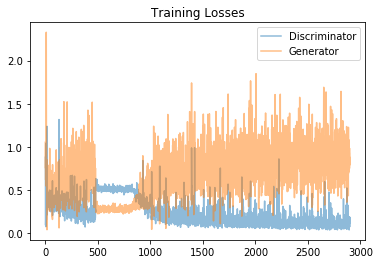

In [22]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [23]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [24]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

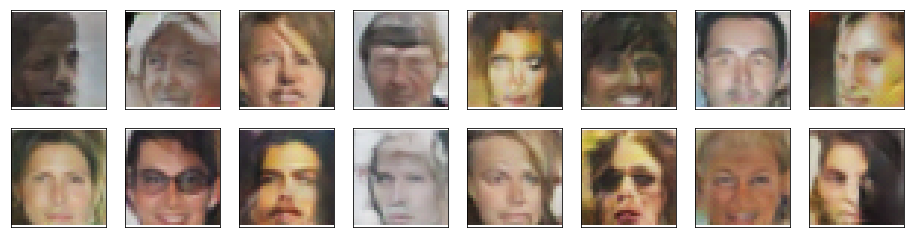

In [25]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** <br>
<em>The generated images are not very clear, but then too it seems to be satisfactory as I have trained for less number of epochs and also because the dataset of human faces is complex. </em>
    <ul>
    <li>
        <p>The generated images appear to have more than one skin color, it is because celebrities have used makeup which makes the classification task difficult. To improve the model we can categorize dataset further based on skin color, sex and hairs which can make classification better.<p>
    </li>
    <li>
        <p>Yes the model size is small. If we increase the model size so it will be abe to learn more features in a data feature space.<p>
    </li>
    <li>
        <p>Yes, optimizers and number of epochs affect the final result a lot. If I increase the number of epochs to be above 500 it will be able to generate better images, but it is a tradeoff as the time required for training the model will increase.<p>
    </li>
    </ul>

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.